In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from matplotlib import rc
rc('font', family='AppleGothic')
from sklearn.linear_model import LinearRegression

In [7]:
df = pd.read_csv("data/output/df.csv")
processed_df = pd.read_csv("data/output/processed_df.csv")

In [8]:
#1 직업별 평균 스펙
def average_spec_by_job(df):
    # Ensure the 'spec' column is numeric, replacing non-numeric values with NaN
    df['spec'] = pd.to_numeric(df['spec'], errors='coerce')
    
    # Calculate the average spec by job, ignoring NaN values
    average_spec_by_job = df.groupby('job')['spec'].mean().reset_index()
    
    # Fill NaN values with 0 for jobs with no spec data
    average_spec_by_job['spec'] = average_spec_by_job['spec'].fillna(0)
    
    # Ensure all jobs are represented, even if they have no spec data
    all_jobs = list(job_dict.values())  # Ensure all jobs from job_dict are present
    missing_jobs = [job for job in all_jobs if job not in average_spec_by_job['job'].values]
    
    # Create a DataFrame for missing jobs with spec value set to 0
    missing_jobs_df = pd.DataFrame({'job': missing_jobs, 'spec': [0]*len(missing_jobs)})
    
    # Concatenate the missing jobs DataFrame with the existing DataFrame
    average_spec_by_job = pd.concat([average_spec_by_job, missing_jobs_df], ignore_index=True)
    
    # Sort the data for better visualization
    average_spec_by_job = average_spec_by_job.sort_values('spec', ascending=False)
    
    # Set up the visualizations
    plt.figure(figsize=(10, 6))
    sns.barplot(x='spec', y='job', data=average_spec_by_job, palette='viridis')
    
    # Add labels and title
    plt.xlabel('평균스펙')
    plt.ylabel('직업')
    plt.title('직업별 평균 스펙')
    
    # Display the plot
    plt.show()

In [9]:
#2 맵별 직업 분포
def plot_job_frequency_by_map(df):
    # Count the number of occurrences of each job in each map
    job_map_counts = df.groupby(["map", "job"]).size().reset_index(name="count")
    
    # Create a pivot table for better visualization
    job_map_pivot = job_map_counts.pivot(index="map", columns="job", values="count").fillna(0)
    
    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(job_map_pivot, annot=True, fmt=".0f", cmap="YlGnBu", cbar_kws={'label': 'Job Count'})
    plt.title("맵별 직업 분포")
    plt.ylabel("Map")
    plt.xlabel("Job")
    plt.show()

In [10]:
#3 특정 직업 레벨 스펙, 회귀
def plot_level_spec_with_regression(df, input_job):
    job_df = df[df["job"] == input_job].dropna(subset=["level", "spec"])
    
    # Check if there are enough data points for regression
    if len(job_df) < 2:
        print(f"Not enough data points to compute regression for job: {input_job}")
        return

    # Prepare data for linear regression
    X = job_df["level"].values.reshape(-1, 1)
    y = job_df["spec"].values
    
    # Fit linear regression model
    model = LinearRegression()
    model.fit(X, y)
    coef = model.coef_[0]
    intercept = model.intercept_
    
    # Regression equation
    equation = f"Spec = {coef:.2f} * Level + {intercept:.2f}"
    
    # Plot Level vs Spec
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=job_df, x="level", y="spec", s=100, label=f"{input_job} Data")
    sns.lineplot(x=job_df["level"], y=model.predict(X), color="red", label="Regression Line")
    plt.title(f"{input_job}'s Level vs Spec", fontsize=16)
    plt.suptitle(equation, fontsize=12, color="gray")
    plt.xlabel("Level", fontsize=14)
    plt.ylabel("Spec", fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

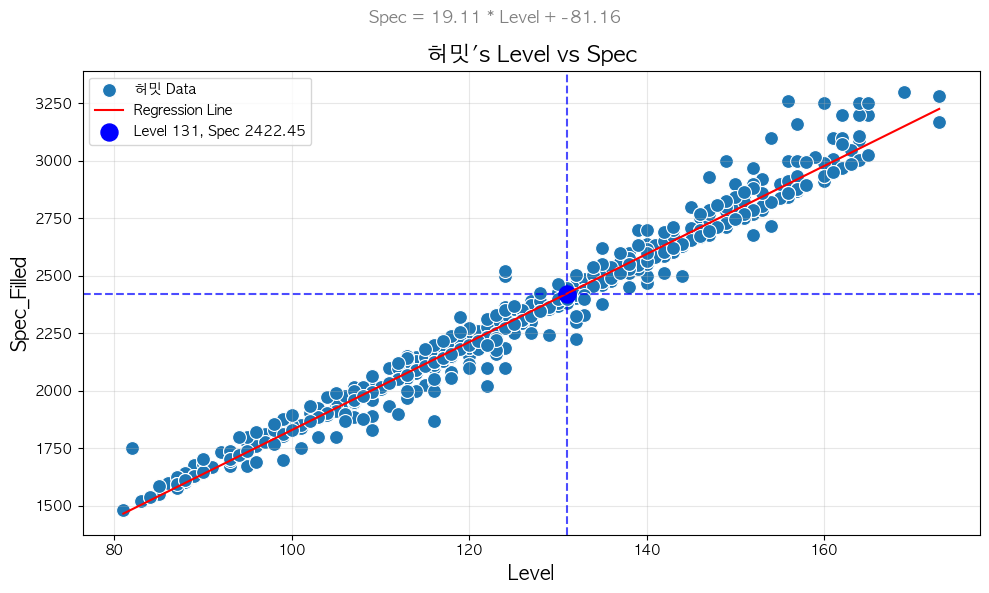

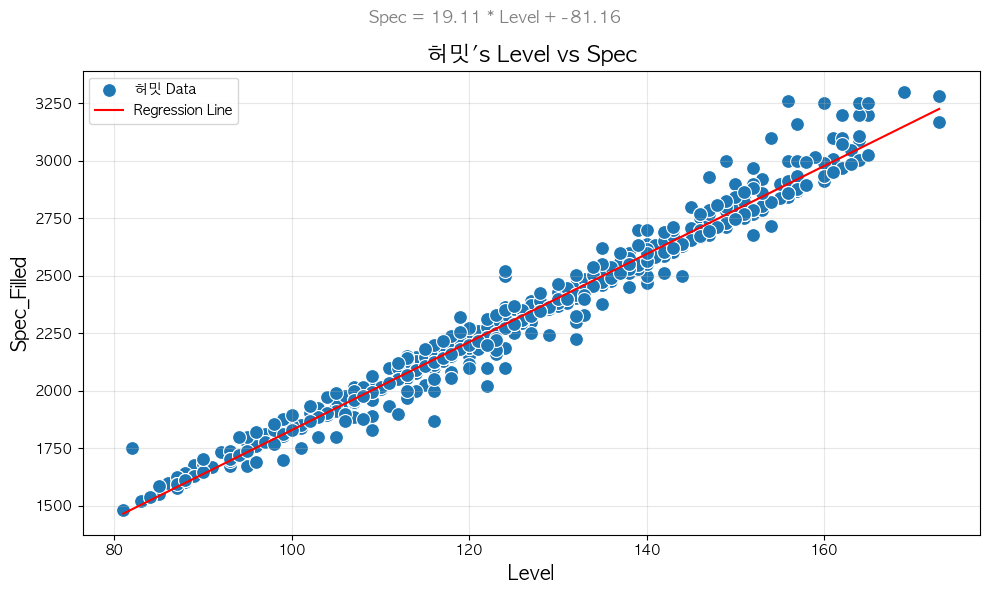

In [15]:
def plot_level_spec_with_regression(df, input_job, input_level=None):
    """
    Plots Level vs Spec for a specific job with a linear regression line and equation.
    Optionally marks a given level on the plot.

    Parameters:
    - df: DataFrame containing the data.
    - input_job: The specific job to filter and plot (e.g., '허밋').
    - input_level: Optional level to mark on the regression line.
    """
    # Filter for the specific job and drop rows with missing data
    job_df = df[df["job"] == input_job].dropna(subset=["level", "spec_filled"])
    
    # Check if there are enough data points for regression
    if len(job_df) < 2:
        print(f"Not enough data points to compute regression for job: {input_job}")
        return

    # Prepare data for linear regression
    X = job_df["level"].values.reshape(-1, 1)
    y = job_df["spec_filled"].values
    
    # Fit linear regression model
    model = LinearRegression()
    model.fit(X, y)
    coef = model.coef_[0]
    intercept = model.intercept_
    
    # Regression equation
    equation = f"Spec = {coef:.2f} * Level + {intercept:.2f}"
    
    # Plot Level vs Spec
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=job_df, x="level", y="spec_filled", s=100, label=f"{input_job} Data")
    sns.lineplot(x=job_df["level"], y=model.predict(X), color="red", label="Regression Line")
    
    # Mark the input level if provided
    if input_level is not None:
        predicted_spec = coef * input_level + intercept
        plt.scatter([input_level], [predicted_spec], color="blue", s=150, label=f"Level {input_level}, Spec {predicted_spec:.2f}")
        plt.axvline(x=input_level, color="blue", linestyle="--", alpha=0.7)
        plt.axhline(y=predicted_spec, color="blue", linestyle="--", alpha=0.7)
    
    # Customize plot
    plt.title(f"{input_job}'s Level vs Spec", fontsize=16)
    plt.suptitle(equation, fontsize=12, color="gray")
    plt.xlabel("Level", fontsize=14)
    plt.ylabel("Spec_Filled", fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_level_spec_with_regression(df, "허밋", input_level=131)